In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

### Данные для построения приложены к домашнему заданию (data.csv)

Привет! В этом задании тебе предстоит построить модель для задачи предсказания дефолта клиента. Тебе предоставлен набор признаков и целевая переменная — факт выхода клиентов в просрочку глубины 4 на горизонте 12 месяцев. Нужно провести анализ признаков и выявить наиболее релевантные к задаче, проанализировать их и простроить линейную модель. Этот проект не имеет жестких ограничений на многие пункты и допускает во многом **вольный подход** к его выполнению: например, мы предлагаем самостоятельно выбрать подход к заполнению пропущенных значений и не накладываем никаких ограничений. Таких пунктов в этом проекте много, цель проста: проанализировать то, как ты **самостоятельно** принимаешь решения. Единственное, советуем **аргументировать** свои решения и стараться **интепретировать** полученные результаты, аргументация будет также учтена при оценивании работы. 

### Как будет оцениваться ваша работа: 
Все пункты (1-12) весят одинаково, итоговая оценка — количество правильно выполненных пунктов. В случае отсутствия аргументации/выводов за пункт ставится 0.5 

### Задание
0. Разбейте выборку на train, val, test (обучение и анализ модели проводите на train). Разбиение аналогично тому, что проводилось на семинаре (60/20/20, без шаффла). В случае иного разбиения модель качество модели будет считаться **невалидным**. 
1. Исследуйте и  заполните пропуски, **обоснуйте** метод и выскажете свои предположения о возможных причинах их появления
2. Отберите все признаки по ROC-AUC > 0.525
3. Проведите EDA для трёх самых сильных признаков. Как думаете, как **интерпретировать** эти зависимости? (https://en.wikipedia.org/wiki/Exploratory_data_analysis)
4. Постройте матрицу корреляций, удалите все сильные корреляты, поясните свой выбор
5. Настройте градиентный бустинг так, чтобы на тесте качество было не меньше **0.646** (тест никак не должен участвовать в настройке модели) (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
6. Визуализируйте 7 самых сильных признаков по gain (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html) Как думаете, **как работает** самый сильный признак? Почему?(больше -> лучше, меньше -> лучше)
7. Реализуйте функцию **stepwise** для логистической регрессии
8. Отберите признаки с порогами 10 и 15% 
9. Обучите логистическую регрессию на признаках, **отобранных** по stepwise
9. Визуализируйте силу признаков линейной модели
10. Сильно ли различается результат по сравнению с бустингом? Как думаете, **почему**?
11. Посчитайте **на тесте** ROC-AUC вашей модели, как считаете, не переобучилась ли она?

### Описание признаков

1. max_util (максимальная утилизация по КК)
2. avg_util (средняя утилизация по КК)
3. credits_2y (количество кредитов за последние 2 года)
4. credits_4y (количество кредитов за последние 4 года)
5. bad_history_credits_flg (наличие кредитов в подозрительных кредитных организациях)
6. other_util (отношение задолженности к сумме кредитов в других организациях)
7. avg_term (средний срок кредита)
8. min_term (минимальный срок кредита)
9. avg_limit_mortgage (средний лимит по ипотекам)
10. min_limit_mfo (минимальный лимит в мфо)
11. close_balance_amt (выплаченная сумма)
12. soc_dem_score (скоринговый балл основанный на соц-дем показателях)
13. max_delq_cnt (максимальное число просрочек по кредиту)
14. avg_active_time (среднее оставшееся время по открытам кредитам)
15. last_credit_time_years (время (в годах) с последнего закрытого кредита)

### Чек лист готовности работы ('x' чтобы поставить галочку)

- [x]  Признаки отобраны по ROC-AUC
- [x]  EDA проведён
- [x]  Корреляты удалены
- [x]  Градиентный бустинг обучен и достигает нужного качества
- [x]  Самые сильные признаки отобраны
- [x]  Stepwise реализован 
- [x]  Линейная модель обучена, проанализирована сила признаков 
- [x]  Метрики на тесте посчитаны
- [x]  Проведено сравнение качества моделей, выдвинуты гипотезы о причинах наблюдаемых результатов

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier, plot_importance
from IPython.display import clear_output
from scipy.stats.distributions import chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('scoring_model_data.csv')

In [4]:
df.head()

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,0.0,0.0,2019-01-01,0.991360,0.991360,0.0,1.0,1.0,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0
1,1.0,0.0,2019-01-01,0.928482,0.271159,0.0,0.0,1.0,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0
2,2.0,0.0,2019-01-01,1.418333,0.079951,0.0,0.0,1.0,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0
3,3.0,0.0,2019-01-01,1.042425,0.230797,1.0,1.0,1.0,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0
4,4.0,1.0,2019-01-01,0.960127,0.326562,2.0,2.0,1.0,0.334188,188.200000,1.0,-1.0,-1.0,53620.00,-7.226236,0.0,14.0,2.0


# Задание 0

In [5]:
def test_val_split(df, val_size=0.2, test_size=0.2):
    
    """
        Функция для разбиения выборки на три части по времени (hold-out подход)
        
        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        val_size : str
            размер валидационной выборки
        test_size : str
            размер тестовой выборки

        Returns
        ---
        df : pandas.DataFrame
           исходный датафрейм с новой колонкой sample_part принимающей три значения:
           'train', 'val', 'test'

    """
    
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df['d4p12'], test_size=val_size+test_size, shuffle=False)
    df.assign(sample_part='')
    df.loc[X_test.index, 'sample_part'] = 'test'
    X_val, X_test, y_val, y_test = train_test_split(
        df[features][df['sample_part'] == 'test'], df['d4p12'][df['sample_part'] == 'test'],\
        test_size=test_size / (test_size + val_size), shuffle=False)
    df.loc[X_val.index, 'sample_part'] = 'validation'
    df.loc[X_train.index, 'sample_part'] = 'train'
    return df

In [6]:
features = [\
    'max_util', 
    'avg_util',
    'credits_2y',
    'credits_4y',
    'bad_history_credits_flg',
    'other_util', 'avg_term',
    'min_term',
    'avg_limit_mortgage',
    'min_limit_mfo', 
    'close_balance_amt',
    'soc_dem_score',
    'max_delq_cnt',
    'avg_active_time',
    'last_credit_time_years'
]

In [7]:
df = df.sort_values(by=['user_id'])
df_split = test_val_split(df, val_size=0.2, test_size=0.2)

In [8]:
df_split

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years,sample_part
0,0.0,0.0,2019-01-01,0.991360,0.991360,0.00000,1.0,1.0,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0,train
222275,0.0,-20.0,1349455.0,-1.000000,612562.000000,-6.70908,0.0,127.0,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,1.0,0.0,2019-01-01,0.928482,0.271159,0.00000,0.0,1.0,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0,train
2,2.0,0.0,2019-01-01,1.418333,0.079951,0.00000,0.0,1.0,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0,train
3,3.0,0.0,2019-01-01,1.042425,0.230797,1.00000,1.0,1.0,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230532,222272.0,0.0,2020-02-01,0.977820,0.471089,0.00000,0.0,1.0,0.472426,233.666667,1.0,-1.0,-1.0,604718.31,-8.521999,0.0,42.0,1.0,test
230533,222273.0,0.0,2020-02-01,0.756241,0.756241,1.00000,1.0,0.0,0.837179,57.000000,57.0,-1.0,-1.0,60327.00,-5.990489,0.0,NaN,1.0,test
222273,222273.0,0.0,2020-02-01,0.756241,0.756241,1.00000,1.0,0.0,0.837179,57.000000,57.0,-1.0,-1.0,60327.00,-5.990489,0.0,NaN,1.0,test
222274,222274.0,0.0,2020-02-01,0.773513,0.249006,0.00000,0.0,1.0,0.277054,4.769231,-82.0,2709000.0,-1.0,720028.00,-8.987482,0.0,151.0,2.0,test


# Задание 1

In [9]:
pd.unique(df_split['d4p12'])

array([  0., -20.,   1.])

-20 - недействительное значение таргета (бинарной классификации)

In [10]:
df_split[df_split['d4p12'] == -20]

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years,sample_part
222275,0.0,-20.0,1349455.0,-1.0,612562.0,-6.70908,0.0,127.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


Удалим этот объект:

In [11]:
df_split.drop(df_split[df_split['d4p12'] == -20].index[0], inplace=True)
pd.unique(df_split['d4p12'])

array([0., 1.])

Перейдём к остальных признакам:

In [12]:
df_split.isna().any()

user_id                    False
d4p12                      False
month_dt                   False
max_util                   False
avg_util                   False
credits_2y                 False
credits_4y                 False
bad_history_credits_flg    False
other_util                 False
avg_term                    True
min_term                    True
avg_limit_mortgage         False
min_limit_mfo              False
close_balance_amt          False
soc_dem_score              False
max_delq_cnt               False
avg_active_time             True
last_credit_time_years     False
sample_part                False
dtype: bool

Так же были замечены объекты-клоны с повторяющимися значениями признаков (видно из последнего вызова df_split

In [13]:
df_split.drop_duplicates(subset=['user_id'], keep='first', inplace=True)

In [14]:
df_split

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years,sample_part
0,0.0,0.0,2019-01-01,0.991360,0.991360,0.0,1.0,1.0,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0,train
1,1.0,0.0,2019-01-01,0.928482,0.271159,0.0,0.0,1.0,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0,train
2,2.0,0.0,2019-01-01,1.418333,0.079951,0.0,0.0,1.0,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0,train
3,3.0,0.0,2019-01-01,1.042425,0.230797,1.0,1.0,1.0,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0,train
4,4.0,1.0,2019-01-01,0.960127,0.326562,2.0,2.0,1.0,0.334188,188.200000,1.0,-1.0,-1.0,53620.00,-7.226236,0.0,14.0,2.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222270,222270.0,0.0,2020-02-01,0.659032,0.195308,0.0,0.0,1.0,0.269778,13.000000,-14.0,1920000.0,-1.0,1049286.00,-7.506231,0.0,70.0,0.0,test
222271,222271.0,0.0,2020-02-01,0.985722,0.222866,0.0,0.0,0.0,0.271445,16.916667,-57.0,2100000.0,51953.0,944428.00,-6.933236,0.0,176.0,0.0,test
222272,222272.0,0.0,2020-02-01,0.977820,0.471089,0.0,0.0,1.0,0.472426,233.666667,1.0,-1.0,-1.0,604718.31,-8.521999,0.0,42.0,1.0,test
230533,222273.0,0.0,2020-02-01,0.756241,0.756241,1.0,1.0,0.0,0.837179,57.000000,57.0,-1.0,-1.0,60327.00,-5.990489,0.0,NaN,1.0,test


In [15]:
df_split.groupby('sample_part')['user_id'].count() / 222275

sample_part
test          0.170276
train         0.622292
validation    0.207432
Name: user_id, dtype: float64

Требуется перераспределить выборку после удаления объектов

In [16]:
df_split = test_val_split(df_split, val_size=0.2, test_size=0.2)
df_split.groupby('sample_part')['user_id'].count() / 222275

sample_part
test          0.2
train         0.6
validation    0.2
Name: user_id, dtype: float64

In [17]:
for feature in ['avg_term', 'min_term', 'avg_active_time']:
    print(feature, pd.unique(df_split[feature]))

avg_term [ 2.90000000e+01  8.69285714e+01 -6.57894737e-02 ...  6.59062500e+01
  1.31631579e+02  3.00800000e+01]
min_term [ 2.900e+01  1.000e+00 -2.400e+01 -5.000e+00 -8.000e+01 -2.900e+01
 -2.000e+00 -2.700e+01  1.000e+01 -4.800e+01 -1.500e+01 -1.400e+01
  6.000e+00  2.600e+01 -3.000e+00 -9.000e+01 -6.000e+00 -1.130e+02
  1.007e+03 -3.000e+01  5.300e+01 -7.300e+01 -4.600e+01  1.200e+01
 -4.000e+00 -8.200e+01 -1.800e+01 -5.100e+01 -1.050e+02 -6.800e+01
 -4.900e+01  3.900e+01 -5.300e+01  3.600e+01 -1.900e+01 -3.100e+01
 -2.600e+01 -9.000e+00 -7.600e+01 -6.500e+01  2.000e+00 -1.100e+01
 -1.379e+03  2.500e+01 -6.900e+01  2.200e+01 -9.500e+01  2.700e+01
 -8.700e+01 -1.200e+01 -2.000e+01 -4.400e+01  0.000e+00 -8.000e+00
 -1.600e+01  2.220e+02  8.000e+00 -7.000e+01 -4.700e+01 -9.600e+01
  3.800e+01 -4.200e+01 -1.000e+01 -1.700e+01 -9.400e+01  5.700e+01
 -4.500e+01  3.000e+00 -1.520e+02 -9.700e+01 -5.500e+01  1.400e+01
 -7.000e+00 -3.700e+01 -1.000e+00 -8.300e+01 -5.900e+01 -9.100e+01
 -4.000e

In [18]:
df[df['avg_term'].isna()]

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years,sample_part
2370,2370.0,0.0,2019-01-01,0.000000,0.000000,1.0,1.0,1.0,0.178405,NaN,NaN,-1.0,-1.0,0.0,-5.923419,0.0,NaN,1.0,train
4507,4507.0,0.0,2019-01-01,1.007200,1.007200,0.0,0.0,1.0,1.000000,NaN,NaN,-1.0,-1.0,6233.0,-4.300473,1.0,NaN,0.0,train
16896,16896.0,0.0,2019-01-01,0.643950,0.643950,0.0,0.0,1.0,0.682830,NaN,NaN,-1.0,-1.0,38447.0,-5.979189,0.0,NaN,0.0,train
17511,17511.0,0.0,2019-01-01,0.000000,0.000000,0.0,0.0,0.0,0.181634,NaN,NaN,-1.0,-1.0,92465.0,-5.730109,0.0,NaN,0.0,train
19747,19747.0,0.0,2019-01-01,0.000000,0.000000,0.0,0.0,1.0,0.208086,NaN,NaN,-1.0,-1.0,0.0,-4.846165,0.0,NaN,0.0,train
25656,25656.0,0.0,2019-02-01,0.000000,0.000000,1.0,1.0,0.0,0.205131,NaN,NaN,-1.0,-1.0,375.0,-5.012653,0.0,NaN,1.0,train
25961,25961.0,1.0,2019-02-01,1.012580,1.012580,0.0,0.0,1.0,1.000000,NaN,NaN,-1.0,-1.0,4049.0,-2.882265,0.0,NaN,0.0,train
34902,34902.0,0.0,2019-02-01,0.000000,0.000000,0.0,0.0,1.0,0.215763,NaN,NaN,-1.0,-1.0,0.0,-4.617147,0.0,NaN,0.0,train
43570,43570.0,0.0,2019-03-01,0.000000,0.000000,0.0,1.0,1.0,0.202293,NaN,NaN,-1.0,-1.0,0.0,-5.320757,0.0,NaN,0.0,train
46557,46557.0,0.0,2019-03-01,0.000000,0.000000,0.0,0.0,0.0,0.208137,NaN,NaN,-1.0,-1.0,1034.0,-1.869176,0.0,NaN,0.0,train


Все признаки с пропусками - вещественные, поэтому применим замену пропусков на число, соответствующую WoE = 0

Можно предположить, что причины пропусков (а они как видно из вывода выше возникают одновременно в объектах) вне зависимости от того, пользовался ли клиент банковскими условиями ранее (credits_2y и credits_4y как нулевые так и нет) заключается в недоступности информации (утеряна до попадания в базу данных или при заполненнии)

In [19]:
LogRes = LogisticRegression()
for feat in ['avg_term', 'min_term', 'avg_active_time']:
    X = df_split[feat][(df_split[feat].notna())]
    y = df_split['d4p12'][(df_split[feat].notna())]
    LogRes.fit(np.array(X).reshape(-1,1), np.array(y).reshape(-1,1))
    all_true = (y==1).sum() / len(y)
    all_false = 1 - all_true
    x0 = (np.log(all_true/all_false) - LogRes.intercept_[0]) / LogRes.coef_[0]
    x0 = x0[0]
    df_split[feat].fillna(x0, inplace=True)
    print(feat, x0)

C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


avg_term 99.00401397628372


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


min_term -12.83607724362954


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


avg_active_time 141.75884339517657


In [20]:
df_split.isna().any()

user_id                    False
d4p12                      False
month_dt                   False
max_util                   False
avg_util                   False
credits_2y                 False
credits_4y                 False
bad_history_credits_flg    False
other_util                 False
avg_term                   False
min_term                   False
avg_limit_mortgage         False
min_limit_mfo              False
close_balance_amt          False
soc_dem_score              False
max_delq_cnt               False
avg_active_time            False
last_credit_time_years     False
sample_part                False
dtype: bool

# Задание 2

In [21]:
y_train = df_split[df_split['sample_part'] == 'train']['d4p12']
for feat in features:
    X_train = df_split[df_split['sample_part'] == 'train'][feat]
    model = LogisticRegression(penalty='none', max_iter=1000)
    model.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
    pred_val = model.predict_proba(np.array(X_train).reshape(-1,1))
    print(feat,roc_auc_score(y_train, pred_val[:,1]))

C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


max_util 0.6203618961454247


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


avg_util 0.5918694255015882


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


credits_2y 0.5659348681873579


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


credits_4y 0.5751022828148034


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


bad_history_credits_flg 0.5039878475484989


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


other_util 0.59013181314255


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


avg_term 0.5223690162195056


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


min_term 0.5040539917167367


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


avg_limit_mortgage 0.537354953318912


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


min_limit_mfo 0.5467836328436504


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


close_balance_amt 0.5449013054816103


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


soc_dem_score 0.5961234826703572


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


max_delq_cnt 0.4994575649321417


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


avg_active_time 0.5270088306020377


C:\Users\user\miniconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


last_credit_time_years 0.5973283091577715


In [22]:
good_features = [\
    'max_util', 
    'avg_util',
    'credits_2y',
    'credits_4y',
    'other_util',
    'avg_limit_mortgage',
    'min_limit_mfo', 
    'close_balance_amt',
    'soc_dem_score',
    'avg_active_time',
    'last_credit_time_years'
]

# Задание 3

In [23]:
df_split.describe()

,user_id,d4p12,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
count,222275.000000,222275.000000,222275.000000,222275.000000,222275.000000,222275.000000,222275.000000,222275.000000,222275.000000,222275.000000,2.222750e+05,2.222750e+05,2.222750e+05,222275.000000,222275.000000,222275.000000,222275.000000
mean,111137.000000,0.062486,1.216911,0.290812,0.338432,0.508483,0.869652,0.333357,95.592668,-13.009982,4.495344e+05,7.704000e+03,8.156312e+05,-6.109266,0.049434,135.832459,1.231079
std,64165.409879,0.242036,9.238953,1.099710,0.612915,0.761547,0.336686,0.190708,140.738748,79.490916,1.351965e+06,6.528288e+04,3.216018e+06,1.751097,0.598957,430.440978,2.555148
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.159623,-360.214286,-1452.000000,-1.000000e+00,-1.000000e+00,0.000000e+00,-14.101289,0.000000,-181.000000,0.000000
25%,55568.500000,0.000000,0.665415,0.091778,0.000000,0.000000,1.000000,0.218275,14.400000,-38.000000,-1.000000e+00,-1.000000e+00,8.026350e+04,-7.285441,0.000000,11.000000,0.000000
50%,111137.000000,0.000000,0.939233,0.194666,0.000000,0.000000,1.000000,0.258053,46.722222,-5.000000,-1.000000e+00,-1.000000e+00,2.979720e+05,-6.099251,0.000000,49.000000,1.000000
75%,166705.500000,0.000000,0.998800,0.348042,1.000000,1.000000,1.000000,0.356656,132.500000,1.000000,-1.000000e+00,-1.000000e+00,8.178395e+05,-4.922499,0.000000,136.000000,2.000000
max,222274.000000,1.000000,1821.747200,205.623958,13.000000,14.000000,1.000000,1.000000,14784.000000,1130.000000,2.400000e+08,2.000000e+07,7.277486e+08,1.379810,53.000000,29524.000000,201.000000


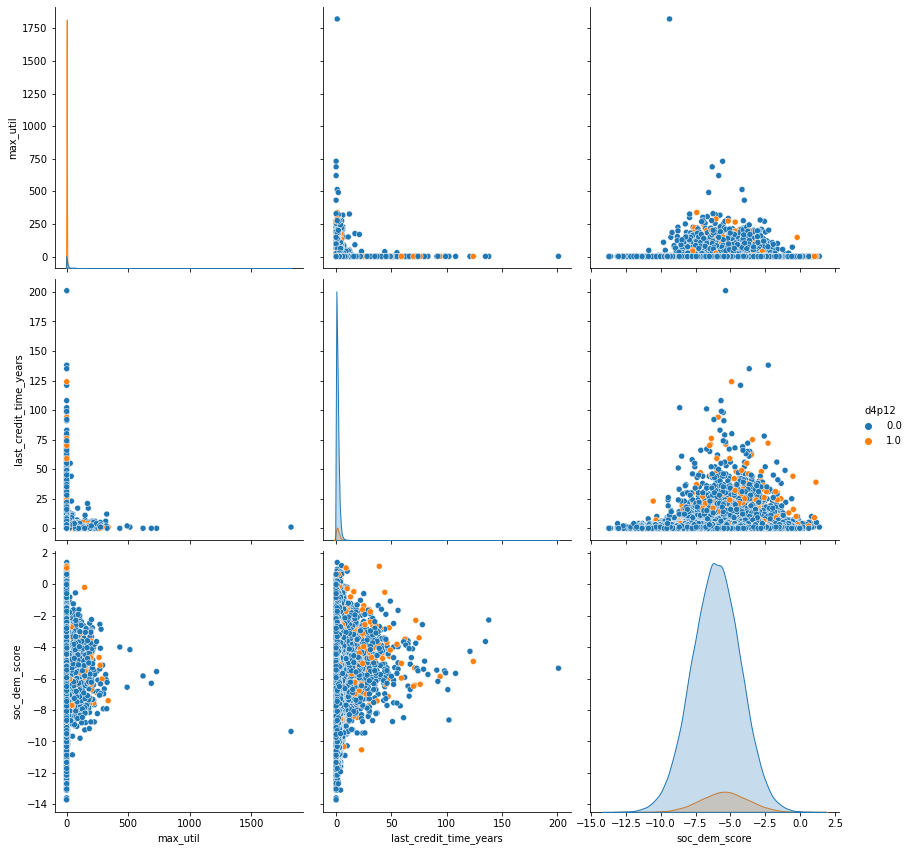

In [24]:
sns.pairplot(df_split[df_split['sample_part']=='train'][['d4p12','max_util','last_credit_time_years', 'soc_dem_score']],
            hue='d4p12', height=4, diag_kind='kde')

Рассмотрение попарного распределения признаков среди первых 3-х (по значению roc_auc) показало крайне слабую линейную (да и просто визуальную зависимость) как между признаками так и с целевой переменной

# Задание 4

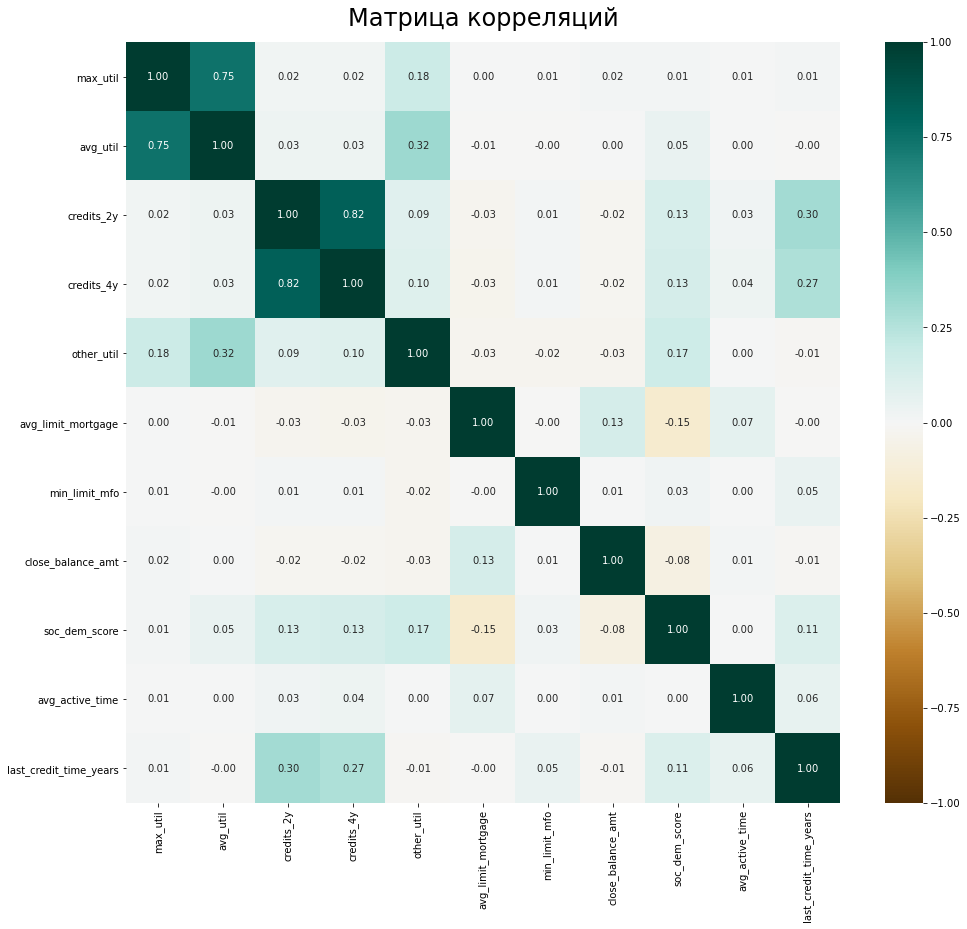

In [25]:
plt.figure(figsize=(16, 14))


heatmap = sns.heatmap(df[good_features].corr(), mask=None, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f")
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

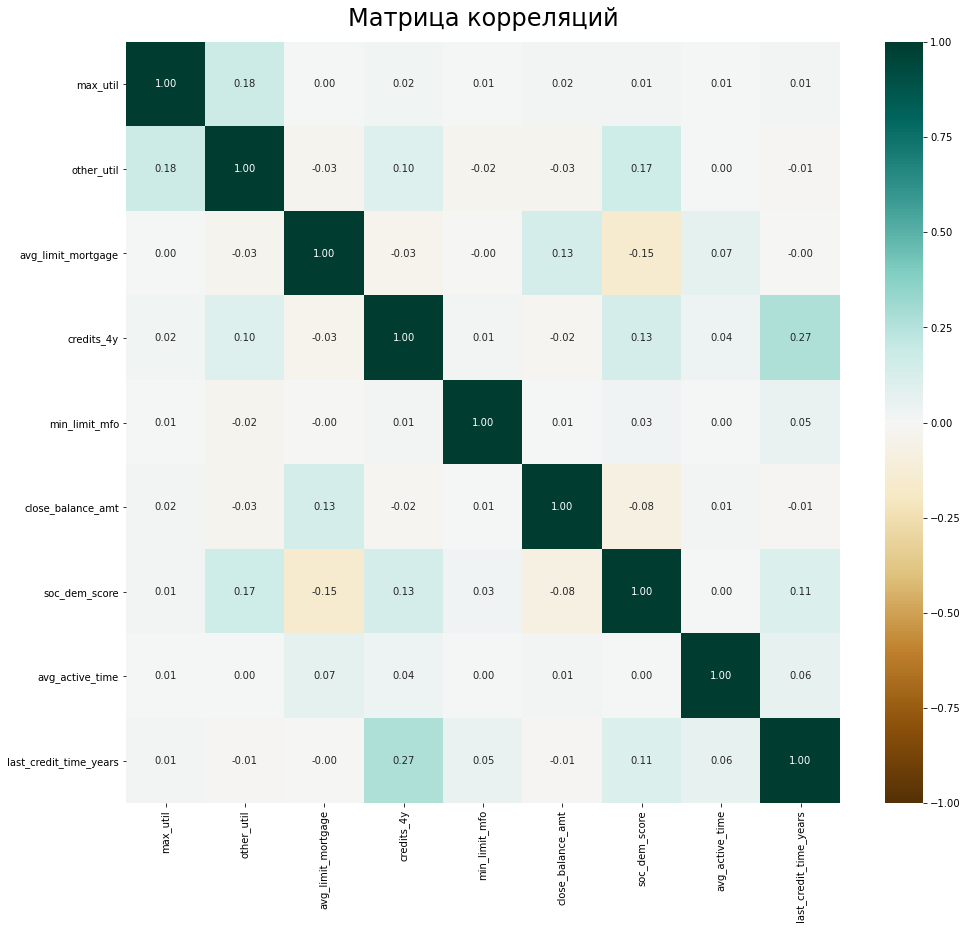

In [26]:
better_features = [
    'max_util',
    'other_util',
    'avg_limit_mortgage',
    'credits_4y',
    'min_limit_mfo', 
    'close_balance_amt',
    'soc_dem_score',
    'avg_active_time',
    'last_credit_time_years'
]

plt.figure(figsize=(16, 14))


heatmap = sns.heatmap(df[better_features].corr(), mask=None, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f")
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

# Задание 5

In [27]:
X_train = df_split[df_split['sample_part']=='train'][good_features]
y_train = df_split[df_split['sample_part']=='train']['d4p12']

X_val=df_split[(df_split['sample_part']=='validation')][good_features]
y_val=df_split[(df_split['sample_part']=='validation')]['d4p12']

X_test=df_split[(df_split['sample_part']=='test')][good_features]
y_test=df_split[(df_split['sample_part']=='test')]['d4p12']


In [28]:
def grid_search(X_train,
                X_val,
                y_train,
                y_val,
                params_dict):
    grid_of_pars = ParameterGrid(params_dict)
    length = len(grid_of_pars)
    grid_of_scores = np.zeros(length)
    for i,par_set in enumerate(grid_of_pars):
        print(f'par_set №{i} of {length}: {par_set}')
        grad_boost = LGBMClassifier(max_depth=par_set['m_d'], 
                                    learning_rate=par_set['l_r'], 
                                    n_estimators=par_set['n_e'], random_state=42)
        grad_boost.fit(X_train, y_train)
        score = roc_auc_score(y_val, grad_boost.predict_proba(X_val)[:,1])
        grid_of_scores[i] = score
        clear_output()
    best_model = grid_of_pars[np.argmax(grid_of_scores)]
    best_score = grid_of_scores[np.argmax(grid_of_scores)]
    return best_model, best_score

In [29]:
grad_boost_parameters = {'m_d': [1, 2, 4, 6, 8],
                         'l_r': [0.05, 0.1, 0.2, 0.3],
                         'n_e': [100, 150, 200, 250, 300]
}

grid_search(X_train, X_val, y_train, y_val, grad_boost_parameters)

({'n_e': 250, 'm_d': 4, 'l_r': 0.05}, 0.6622391361047816)

In [30]:
grad_boost = LGBMClassifier(max_depth=4, learning_rate=0.05, 
                                    n_estimators=250, random_state=42)



grad_boost.fit(X_train,y_train)

roc_auc_score(y_test, grad_boost.predict_proba(X_test)[:,1])

0.6445221856778451

In [31]:
roc_auc_score(y_train, grad_boost.predict_proba(X_train)[:,1])

0.7155370364230655

# Задание 6

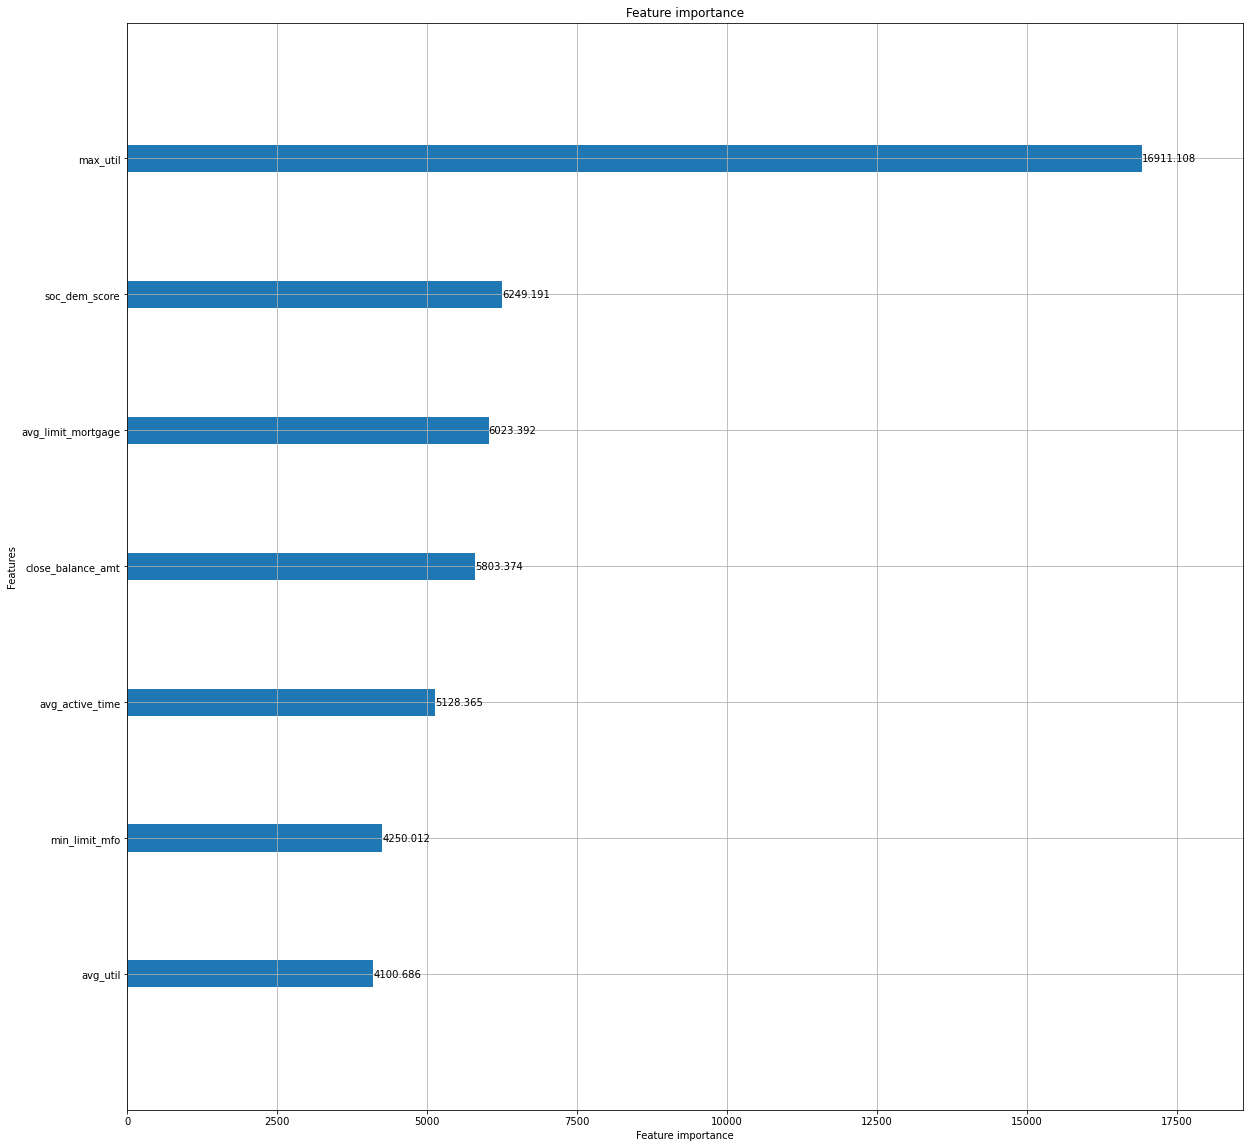

In [32]:
plot_importance(grad_boost, importance_type='gain', max_num_features=7, figsize=(20, 20), precision=3)
plt.show()

# Задание 7

In [33]:
def likelihood_ratio_test(ll_short, ll_long):
    
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [34]:
def stepwise(df, features, target='d4p12', alpha_in=0.1, alpha_out=0.15):
    
    selected_features = list()
    n = df.shape[0]
    p_value = 1
    while True:
        potential_features = list(set(features) - set(selected_features))
        best_feature = ''
        for feature in potential_features:
            temp_features = [feature] + selected_features
            lr_short = LogisticRegression(penalty='none', max_iter=500)
            lr_long = LogisticRegression(penalty='none', max_iter=500)
            if len(selected_features) == 0:
                const = pd.Series([1]*df.shape[0])
                lr_short.fit(np.array(const).reshape(-1, 1), df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(np.array(const).reshape(-1, 1))[:, 1], normalize=False) 
                lr_long.fit(np.array(df[temp_features]).reshape(-1, 1), df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(np.array(df[temp_features]).reshape(-1, 1))[:, 1], normalize=False)
            else:
                lr_short.fit(df[selected_features], df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(df[selected_features])[:, 1], normalize=False)
                lr_long.fit(df[temp_features], df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(df[temp_features])[:, 1], normalize=False)
            if likelihood_ratio_test(ll_short, ll_long) < alpha_in and likelihood_ratio_test(ll_short, ll_long) < p_value:
                p_value = likelihood_ratio_test(ll_short, ll_long)
                best_feature = feature
        if best_feature == '':
            break
        
        selected_features.append(best_feature)
        print(f"В модель была добавлена переменная {best_feature}, p-value: {round(p_value, 4)}")
        p_value = 1
        
        if len(selected_features) > 1:
            p_value_out = 0
            worst_feature = ''
            for feature in selected_features:
                temp_features = list(set(selected_features) - set([feature]))
                lr_short = LogisticRegression(penalty='none', max_iter=500)
                lr_long = LogisticRegression(penalty='none', max_iter=500)
                lr_long.fit(df[selected_features], df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(df[selected_features])[:, 1], normalize=False)
                lr_short.fit(df[temp_features], df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(df[temp_features])[:, 1], normalize=False)
                if likelihood_ratio_test(ll_short, ll_long) > alpha_out and likelihood_ratio_test(ll_short, ll_long) > p_value_out:
                    p_value_out = likelihood_ratio_test(ll_short, ll_long)
                    worst_feature = feature
            if worst_feature != '':
                selected_features = list(set(selected_features) - set([worst_feature]))
                print(f"Из модели была убрана переменная {worst_feature}, p-value: {round(p_value_out, 4)}")
            p_value_out = 0
            
    return selected_features

# Задание 8

In [35]:
stepwise(df_split[df_split['sample_part']=='train'][better_features + ['d4p12']], better_features)

В модель была добавлена переменная soc_dem_score, p-value: 0.0
В модель была добавлена переменная credits_4y, p-value: 0.0
В модель была добавлена переменная other_util, p-value: 0.0
В модель была добавлена переменная last_credit_time_years, p-value: 0.0
В модель была добавлена переменная avg_active_time, p-value: 0.0087


['soc_dem_score',
 'credits_4y',
 'other_util',
 'last_credit_time_years',
 'avg_active_time']

# Задание 9

In [36]:
best_features = ['soc_dem_score',
                 'credits_4y',
                 'other_util',
                 'last_credit_time_years',
                 'credits_2y']

pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500))])
pipe.fit(df[best_features][df['sample_part'] == 'train'],\
         df['d4p12'][df['sample_part'] == 'train'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1500, penalty='none'))])

# Задание 10

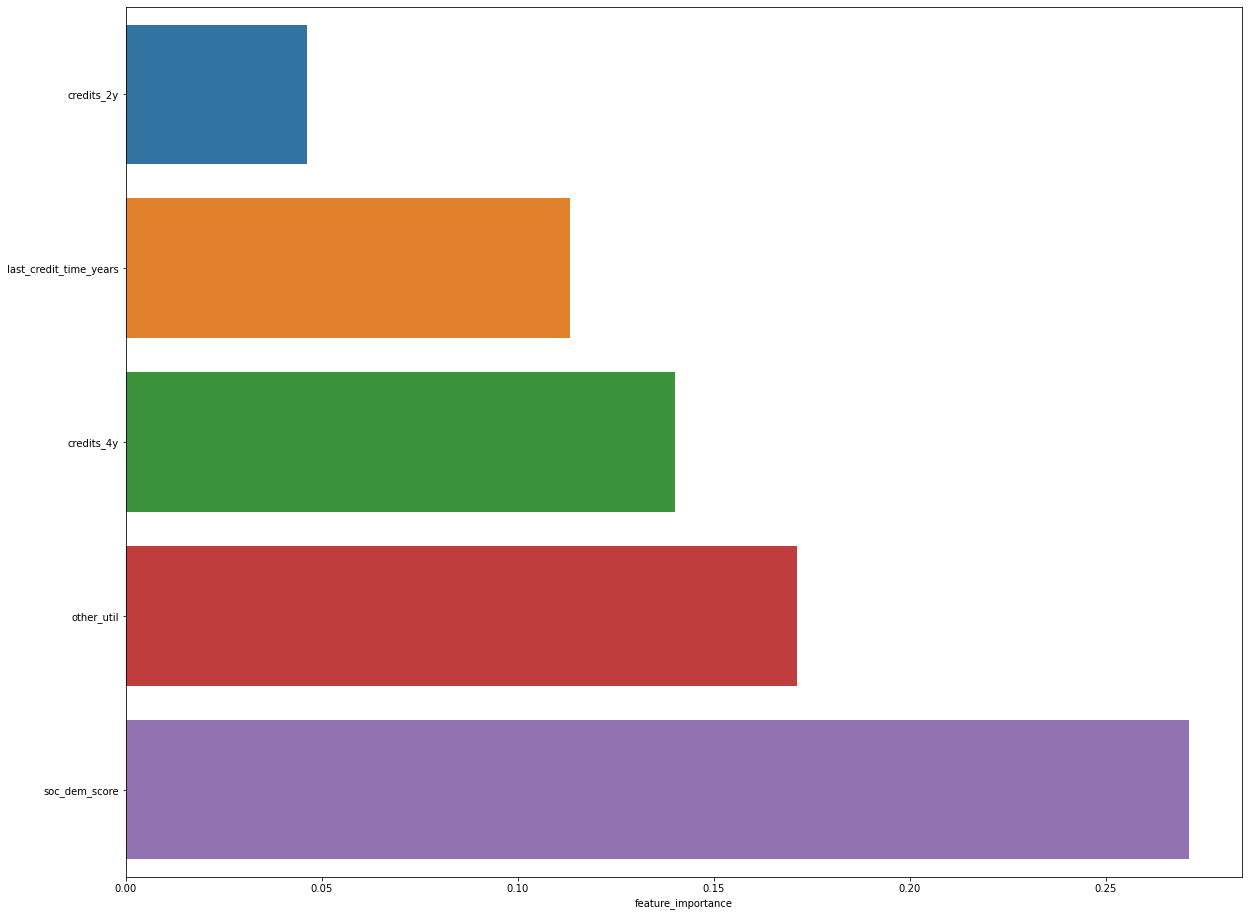

In [37]:
coef = pd.DataFrame(pipe.get_params()['model'].coef_[0],index=best_features, columns=['feature_importance']).sort_values(by=['feature_importance'])
plot = sns.barplot(y=coef.index, x=coef['feature_importance'])
plot.figure.set_size_inches(20, 16)

# Задание 11

Значимость признаков сильно отличается - признак soc_dem_score единственный, присутствующий в "топе" обоих моделей, хотя max_util, стоящий выше по значимости в бустинге, не был принят алгоритмом stepwise. Можно предположить, что алгоритм нашёл более линейно-информативные, но более слабые признаки.

По результатам EDA не было визульально зафиксировано линейных зависимостей целевой переменной от сильнейших признаков, что может говорить от том, что Логистическая регрессия не подходит к данной задаче.

# Задание 12

За значениями roc_auc см. пункт 5

Grad_boost

Train roc_auc: 0.7155370364230655
    
Val roc_auc: 0.6622391361047816

Test roc_auc: 0.6445221856778451

Разница в roc_auc существует, но достаточно плавная, что говорит о незначительном переобучении

Log_Reg

In [38]:
roc_auc_score(df['d4p12'][df['sample_part'] == 'train'], pipe.predict_proba(df[best_features][df['sample_part'] == 'train'])[:,1])

0.6376972936543035

In [39]:
roc_auc_score(df['d4p12'][df['sample_part'] == 'validation'], pipe.predict_proba(df[best_features][df['sample_part'] == 'validation'])[:,1])

0.6077165521236556

In [40]:
roc_auc_score(df['d4p12'][df['sample_part'] == 'test'], pipe.predict_proba(df[best_features][df['sample_part'] == 'test'])[:,1])

0.5963291326152659

Разница roc_auc в два раза плавнее, переобучение ещё меньше

In [43]:
import pickle

with open('from_6_dz_with_love.pickle', 'wb') as f:
    pickle.dump(grad_boost, f)